# Выбор локации для скважины

**Задача:** решить, где бурить новую скважину для нефтедобывающей компании.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

План проекта:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import random
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

Изучим данные:

Так как у нас три таблицы, то везде будем писать функции, чтобы не вызывать команду три раза для каждой:

In [2]:
geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
geo_3 = pd.read_csv('/datasets/geo_data_2.csv')
geo_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Легенда таблицы:**
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек;
* product — объём запасов в скважине (тыс. баррелей).

In [5]:
def data_info(data):
    data.info()

In [6]:
data_info(geo_1)
data_info(geo_2)
data_info(geo_3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

Пропусков нет.

Проверим на наличие пропусков:

In [7]:
def data_dupl(data):
    print(data.duplicated().sum())

In [8]:
data_dupl(geo_1)
data_dupl(geo_2)
data_dupl(geo_3)

0
0
0


Дубликатов нет.

In [9]:
def plot_hist(data):
    data['product'].plot(kind='hist', alpha = 0.5)
    plt.xlabel('объём нефти, тыс. бар.')

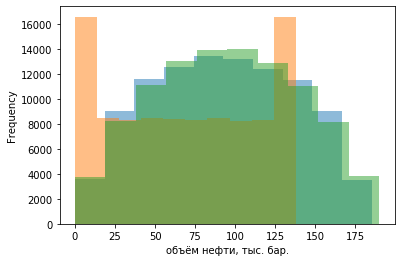

In [10]:
plot_hist(geo_1)
plot_hist(geo_2)
plot_hist(geo_3)

**ВЫВОД:** 
* Дубликатов нет;
* Пропусков нет;
* Построил распределение объёма нефти по регионам. У таблицы geo_1 и geo_2 распределение нормальное. У таблицы geo_3 не нормальное.

## Обучение и проверка модели

Удалим колонки с 'id':

In [11]:
del geo_1['id']
del geo_2['id']
del geo_3['id']

Разбиваем на валидационную и тестовую выборки в соотношении 75:25:

In [12]:
geo1_valid, geo1_train = train_test_split(geo_1, test_size=0.75, random_state=12345) 
geo2_valid, geo2_train = train_test_split(geo_2, test_size=0.75, random_state=12345) 
geo3_valid, geo3_train = train_test_split(geo_3, test_size=0.75, random_state=12345)

Напишем функцию, чтобы задать признаки и целевой признак для наших выборок:

In [13]:
def features_target(data):
    features = data.drop(['product'], axis=1)
    target = data['product']
    return features, target

In [14]:
features1_val, target1_val = features_target(geo1_valid)
features1_tr, target1_tr = features_target(geo1_train)
features2_val, target2_val = features_target(geo2_valid)
features2_tr, target2_tr = features_target(geo2_train)
features3_val, target3_val = features_target(geo3_valid)
features3_tr, target3_tr = features_target(geo3_train)

Посмотрим, есть ли коррелирующие признаки:

In [15]:
geo_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [16]:
geo_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [17]:
geo_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Есть корреляция:
* в geo_1: отрицательная (-0,44) между f0 и f1; положительная (0,48) между product и f2;
* в geo_2: положительная (0,18) между f0 и f1; очень высокая (0,99) корреляция между product и f2; Объём добычи нефти в данном регионе напрямую зависит от параметра f2;
* в geo_3: положительная (0,45) между product и f2.

* Обучим модель для данных **geo1** методом линейной регрессии:

In [18]:
model1 = LinearRegression()
model1.fit(features1_tr, target1_tr)
predictions1 = model1.predict(features1_val)
RMSE1 = mean_squared_error(target1_val, predictions1)**0.5
predictions1_mean = predictions1.mean()

RMSE:

In [19]:
RMSE1

37.68019646464799

Средний запас предсказанного сырья для **geo1**:

In [20]:
predictions1_mean

92.68042230714772

* Обучим модель для данных **geo2** методом линейной регрессии:

In [21]:
model2 = LinearRegression()
model2.fit(features2_tr, target2_tr)
predictions2 = model2.predict(features2_val)
RMSE2 = mean_squared_error(target2_val, predictions2)**0.5
predictions2_mean = predictions2.mean()

* RMSE:

In [22]:
RMSE2

0.887328735465853

Средний запас предсказанного сырья для **geo2**:

In [23]:
predictions2_mean

68.85982082622293

* Обучим модель для данных **geo3** методом линейной регрессии:

In [24]:
model3 = LinearRegression()
model3.fit(features3_tr, target3_tr)
predictions3 = model3.predict(features3_val)
RMSE3 = mean_squared_error(target3_val, predictions3)**0.5
predictions3_mean = predictions3.mean()

RMSE:

In [25]:
RMSE3

40.11167877627781

Средний запас предсказанного сырья для **geo3**:

In [26]:
predictions2_mean

68.85982082622293

**ВЫВОД:** 
* Разбил выборки на тренировочную и валидационную выборки в соотношении 75:25;
* Проверил на мультиколлинеарность, есть сильно коррелирующие признаки в регионе **geo2**. Корреляция порядка 0,99. НО решил не удалять этот признак, так как у нас и так модель небольшая и признаков немного;
* RMSE в регионах geo1 и geo3 имеют схожие значения (37,7 и 40,1);
* RMSE в регионе geo2 равен 0,89 (это говорит о том, что модель хорошо обучилась).

## Подготовка к расчёту прибыли

Введём константы, что даны по заданию:

In [27]:
n_points = 500
points_best = 200
budget = 10000000000
income_per_barrel = 450000

Рассчитваем минимальный объём нефти для скважины для безубыточной работы:

In [28]:
min_value = budget/income_per_barrel/points_best
min_value

111.11111111111111

Для безубыточной работы скважина должна "дать" 111,11 тыс. баррелей.

Сравним полученный объём сырья со средним запасом в каждом регионе:

In [29]:
comparison_V1 = (1 - predictions1_mean/min_value)*100
comparison_V2 = (1 - predictions2_mean/min_value)*100
comparison_V3 = (1 - predictions3_mean/min_value)*100
print(comparison_V1)
print(comparison_V2)
print(comparison_V3)

16.587619923567054
38.02616125639936
14.445155339918802


**ВЫВОД:** 
* Для безубыточной работы скважина должна "дать" 111,11 тыс. баррелей.
* Во всех скважинах средний объём меньше необходимого. Это очень важное замечание;
* В первом регионе средний объём ниже на 16,6% необходимого;
* Во втором регионе средний объём ниже на 38,0% необходимого;
* В третьем регионе средний объём ниже на 14,4% необходимого;

# Расчёт прибыли и рисков 

## Расчёт прибыли

Создадим новые таблицы, где находятся ТОП200 скважин. Для этого сначала соеденим таблицы предсказаний и признаков:

Для предсказаний добавим индексы:

In [30]:
predictions1_df = pd.DataFrame(predictions1)


Сделаем индексы одинаковыми:

In [31]:
predictions1_df.index = features1_val.index

Соеденим таблицы:

In [32]:
geo1_new = features1_val.join(predictions1_df, how='inner')
geo1_new = geo1_new.join(target1_val, how='inner')


Проделаем то же самое с другими регионами:

In [33]:
predictions2_df = pd.DataFrame(predictions2)
predictions3_df = pd.DataFrame(predictions3)
predictions2_df.index = features2_val.index
predictions3_df.index = features3_val.index
geo2_new = features2_val.join(predictions2_df, how='inner')
geo2_new = geo2_new.join(target2_val, how='inner')
geo3_new = features3_val.join(predictions3_df, how='inner')
geo3_new = geo3_new.join(target3_val, how='inner')
geo1_new.set_axis(['f0', 'f1', 'f2', 'product_predict', 'target'],axis = 'columns',inplace = True)
geo2_new.set_axis(['f0', 'f1', 'f2', 'product_predict', 'target'],axis = 'columns',inplace = True)
geo3_new.set_axis(['f0', 'f1', 'f2', 'product_predict', 'target'],axis = 'columns',inplace = True)

Отсортируем и сделаем срез. Выведем ТОП200:

In [34]:
geo1_200 = geo1_new.sort_values(by = 'product_predict', ascending = False)[:200]
geo2_200 = geo2_new.sort_values(by = 'product_predict', ascending = False)[:200]
geo3_200 = geo3_new.sort_values(by = 'product_predict', ascending = False)[:200]

Напишем функцию для расчёта прибыли:

In [35]:
def calculate_income(data):
    income = data['product_predict'].sum()*income_per_barrel
    profit = income - budget
    print('Доход равен: %.2f'% (income/1000000), 'млн. рублей')
    print('Прибыль равна: %.2f'% (profit/1000000), 'млн. рублей')

In [36]:
calculate_income(geo1_200)

Доход равен: 13952.50 млн. рублей
Прибыль равна: 3952.50 млн. рублей


In [37]:
calculate_income(geo2_200)

Доход равен: 12490.30 млн. рублей
Прибыль равна: 2490.30 млн. рублей


In [38]:
calculate_income(geo3_200)

Доход равен: 13448.71 млн. рублей
Прибыль равна: 3448.71 млн. рублей


**ВЫВОД:** 
* Посчитаны доход и прибыль для каждого региона;
* Самый прибыльный - это 1ый регион;
* Самые худшие финансовые показатели у второго региона.

## Расчёт рисков 

Применяем технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли:

In [39]:
#функция расчёта прибыли
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    profit = (selected.sum()*income_per_barrel-budget)
    return profit

state = np.random.RandomState(12345)
    
#функция распределения прибыли
def bootstrap(region,N,count):
    target = region['target']
    probabilities = region['product_predict']
    
    
    values = []
    for i in range(1000):
    # < напишите код здесь>
        target_subsample = target.sample(n=N, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index] 
        values.append(revenue(target_subsample, probs_subsample,count))

    values = pd.Series(values)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 

    mean = values.mean()/1000
    print("Средняя прибыль:%.2f"% mean, 'тыс.рублей')
    print(f'95%-ый доверительный интервал от {(lower/1000):.3} до {(upper/1000):.3} тыс.рублей')
    print(values.hist())
    return values

* Средняя прибыль, 95%ый доверительный интервал и гистограмма распределений для региона **geo1**:

Средняя прибыль:468757.23 тыс.рублей
95%-ый доверительный интервал от -8.55e+04 до 1.03e+06 тыс.рублей
AxesSubplot(0.125,0.125;0.775x0.755)


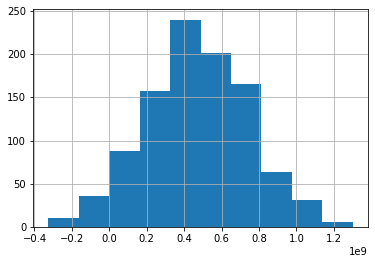

In [40]:
geo1 = bootstrap(geo1_new,500,200)

* Средняя прибыль, 95%ый доверительный интервал и гистограмма распределений для региона **geo2**:

Средняя прибыль:495302.03 тыс.рублей
95%-ый доверительный интервал от 1.1e+05 до 9.37e+05 тыс.рублей
AxesSubplot(0.125,0.125;0.775x0.755)


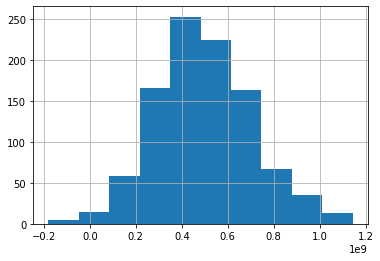

In [41]:
geo2 = bootstrap(geo2_new,500,200)

* Средняя прибыль, 95%ый доверительный интервал и гистограмма распределений для региона **geo3**:

Средняя прибыль:365437.77 тыс.рублей
95%-ый доверительный интервал от -1.85e+05 до 8.93e+05 тыс.рублей
AxesSubplot(0.125,0.125;0.775x0.755)


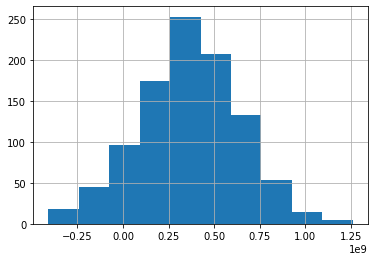

In [42]:
geo3 = bootstrap(geo3_new,500,200)

* Посчитаем вероятность получить отрицательную прибыль для **первого региона**:

In [43]:
len(geo1[geo1 < 0])/len(geo1)*100

4.6

* Посчитаем вероятность получить отрицательную прибыль для **первого региона**:

In [44]:
len(geo2[geo2 < 0])/len(geo2)*100

0.8999999999999999

* Посчитаем вероятность получить отрицательную прибыль для **первого региона**:

In [45]:
len(geo3[geo3 < 0])/len(geo3)*100

10.0

**ВЫВОД:** 
* Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли:
* Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков;
* Худший регион по средней прибыли. Это регион **третий**. Средняя прибыль 365 млн. рублей;
* Лучший регион по средней прибыли. Это регион **второй**. Средняя прибыль 495 млн. рублей;
**ОСНОВНОЙ ВЫВОД:** 
**Лучший регион для ведения добычи - это второй регион (geo2), т.к. там меньше всего риск получить отрицательную прибыль. Также там ожидется максимальная средняя прибыль**